# ICLR Dataset: Summaries for the Paper

(C) Jiayao Zhang 2021-2022

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import print_function, absolute_import, division


import sys, os, json, time, datetime, logging, multiprocessing, itertools
import re, ast, io, logging, tqdm, spacy
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import re, ast, io, logging, tqdm, spacy

tqdm.tqdm.pandas()
logging.getLogger().setLevel(logging.CRITICAL)

In [228]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt


sns.set()

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
matplotlib.rc('font',**{'family':'DejaVu Sans', 'serif':['Times']})
matplotlib.rc('text', usetex=False)
plt.rcParams['figure.figsize'] = (10.0, 8.0)



In [4]:
DATA_PATH = Path('PATH_TO_DB') # replace this to path to DB
DB_NAME = "cs_conf_release.db"
db_con = sqlite3.connect(DATA_PATH/DB_NAME)

In [5]:
import src.utils as utils
import src.data_utils as data_utils

## Load Tables

In [10]:
dataloader = data_utils.DataLoader(db_con=db_con,)

#### Geography

In [160]:
import geopandas as gpd
import pycountry

grp_col = 'iso_a3' #'iso_a3'

sub_reviews_agg = dataloader('sub_reviews_agg')
domain_per_year = dataloader('ins_per_year')
domain_total = dataloader('grp_ins_per_year',grp_col=grp_col)

In [100]:
sns.set(font_scale=2.5,)

sns.set_style("white")
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette("colorblind")


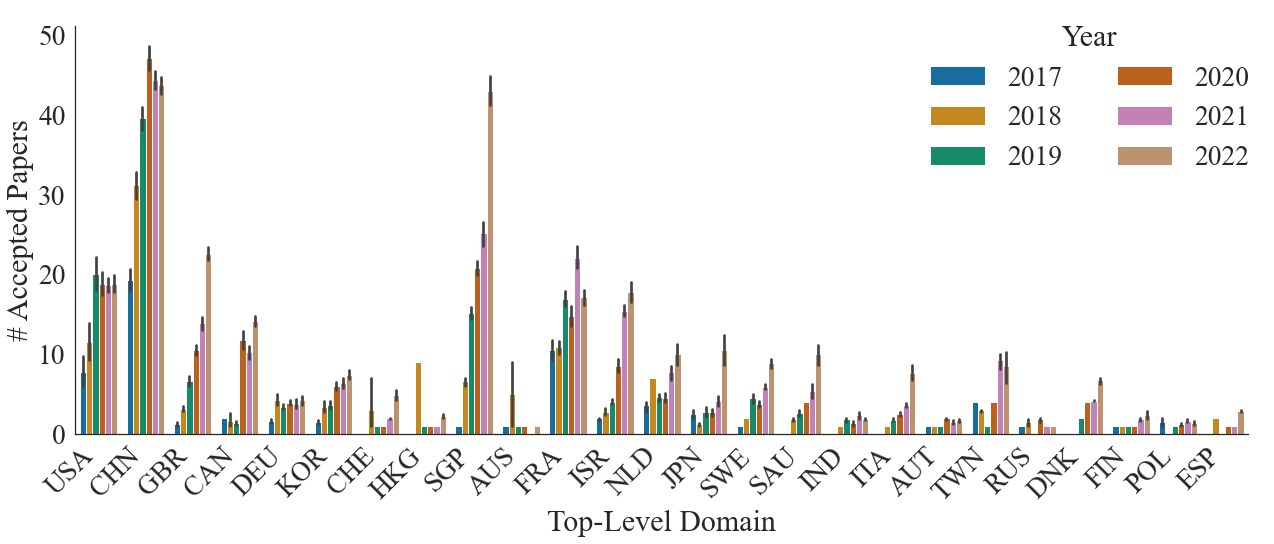

In [22]:
import textwrap
matplotlib.rc('text', usetex=False)

plt_ins = domain_total[grp_col].unique()[:100]
plt_dat = domain_per_year[domain_per_year[grp_col].isin(plt_ins[:25])]
plt_dat=plt_dat.rename({'year':'Year'},axis=1)
plt_dat['Year']=plt_dat['Year'].astype(int)
# plt_dat['Year']=pd.Categorical(plt_dat['Year'],range(2017,2023))
ax = sns.catplot(data=plt_dat,
                  x=grp_col,y='per_year_cnt',
                 hue='Year',kind="bar",
                 height=8, aspect=2, 
                 #              log_scale=(False,True),
            )
ax.set(xlabel=r'Top-Level Domain', #r'ISO Alpha-3 Region Code',
       
       ylabel=r'# Accepted Papers')
ax.set_xticklabels([
    textwrap.fill(label, 12)
    for label in plt_ins[:25]]    
    ,rotation=45,ha='right')

sns.move_legend(ax,loc=1,ncol=2)

plt.tight_layout()
# plt.savefig('./figs/accepted_region.png',bbox_inches='tight')
# plt.savefig('./figs/accepted_region.pdf',bbox_inches='tight')
# plt.savefig('./figs/accepted_domains.png',bbox_inches='tight')
# plt.savefig('./figs/accepted_domains.pdf',bbox_inches='tight')





In [165]:
def get_world_map():
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    for name, ia3 in {
            'Norway': 'NOR',
            'France': 'FRA',
            'N. Cyprus': 'CYP',
            'Kosovo': 'UNK',
            'Somaliland': 'SMO'
        }.items():
        world.loc[world.name==name,'iso_a3']=ia3
    return world

In [34]:
domain_total['acc_rate'] = domain_total['per_year_cnt'] /domain_total.groupby(['iso_a3','year']).total_cnt.transform('first')

In [180]:
sub_reviews_agg['boraderline'] = sub_reviews_agg.rating_avg.apply(lambda x : x > 5 and x < 7)

In [254]:
geo_year_acc = (domain_per_year.groupby(['submission_id', 'year', 'decision'])
    .agg({'iso_a3':pd.Series.mode})
    .reset_index()
    .explode('iso_a3')
#                     .merge(sub_reviews_agg.query("boraderline")[['submission_id', 'rating_avg']], how='inner')

                    
    .groupby(['iso_a3','year'])
    .decision
    .value_counts(normalize=True)
    .unstack(fill_value=0)
 .reset_index()
)

In [279]:
geo_year_acc = (domain_per_year.groupby(['submission_id', 'year', 'decision'])
    .agg({'iso_a3':pd.Series.mode})
    .reset_index()
    .explode('iso_a3')
                    .merge(sub_reviews_agg[['submission_id', 'rating_avg']], how='left')

                    
    .groupby(['iso_a3','year'])
    .submission_id
    .nunique()
#     .value_counts()
#     .unstack(fill_value=0)
 .reset_index()
)

In [280]:
world=get_world_map().merge(
    geo_year_acc.groupby(['iso_a3','year']).submission_id.mean().to_frame().reset_index(),
#     geo_year_acc.query('year==2022'),
    on='iso_a3',how='left')

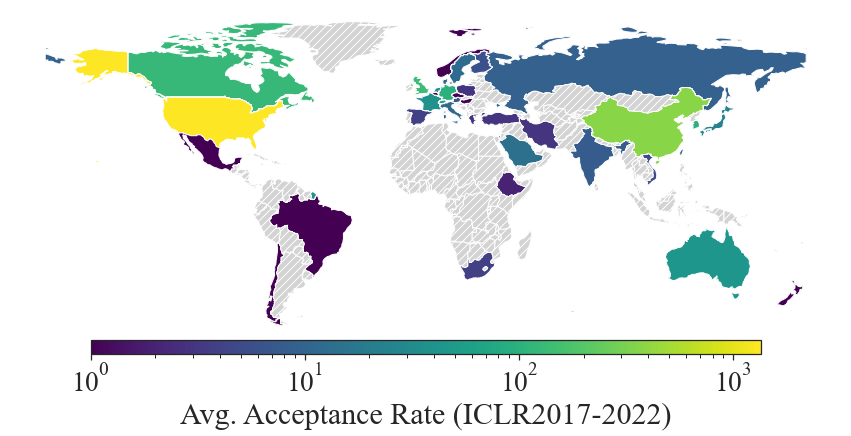

In [281]:
ax = world[world.continent!='Antarctica'].plot(column='submission_id',legend=True,
           figsize=(15, 10),
           norm=matplotlib.colors.LogNorm(vmin=world.submission_id.min(), 
                                          vmax=world.submission_id.max()),
        
        missing_kwds={
        "color": "lightgrey",
#         "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
           cmap='viridis',
    legend_kwds={ 'label': "Avg. Acceptance Rate (ICLR2017-2022)",
        #'label': "# Accepted Papars (ICLR2017-2022)",
                 'shrink':0.8,'aspect':50, 'pad':0,
                        'orientation': "horizontal"},

              
)

ax.set_axis_off()

plt.savefig('./figs/accrate_region.png',bbox_inches='tight')
plt.savefig('./figs/accrate_region.pdf',bbox_inches='tight')


#### avg rating vs geo

In [282]:
geo_year_rating = (domain_per_year.groupby(['submission_id', 'year', 'decision'])
    .agg({'iso_a3':pd.Series.mode})
#     .query("decision=='Accept'")
    .reset_index()
    .explode('iso_a3')
    .merge(sub_reviews_agg[['submission_id', 'rating_avg']], how='left')
    .groupby(['iso_a3','year'])
    .rating_avg
    .mean()
    .to_frame()
 .reset_index()
)

In [283]:
world=get_world_map().merge(
    geo_year_rating.groupby(['iso_a3','year']).rating_avg.mean().to_frame().reset_index(),
#     geo_year_acc.query('year==2022'),
    on='iso_a3',how='left')

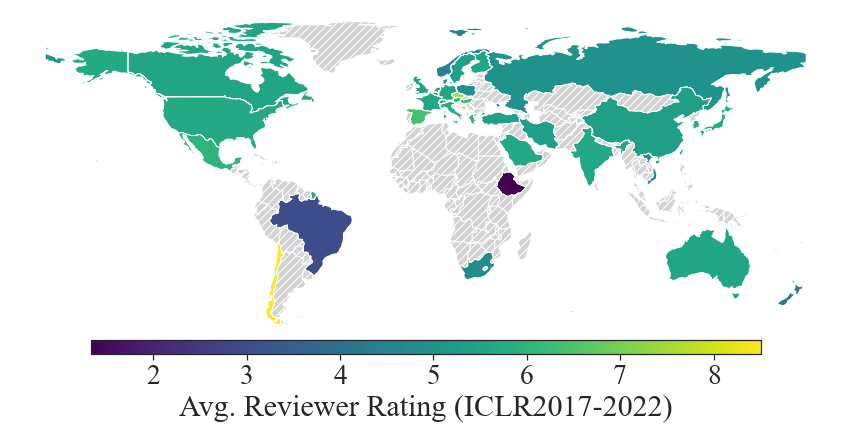

In [285]:
ax = world[world.continent!='Antarctica'].plot(column='rating_avg',legend=True,
           figsize=(15, 10),
#            norm=matplotlib.colors.LogNorm(vmin=world.acc_rate.min(), 
#                                           vmax=world.acc_rate.max()),
        
        missing_kwds={
        "color": "lightgrey",
#         "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
           cmap='viridis',
    legend_kwds={ 'label': "Avg. Reviewer Rating (ICLR2017-2022)",
        #'label': "# Accepted Papars (ICLR2017-2022)",
                 'shrink':0.8,'aspect':50, 'pad':0,
                        'orientation': "horizontal"},

              
)

ax.set_axis_off()

plt.savefig('./figs/avgrating_region.png',bbox_inches='tight')
plt.savefig('./figs/avgrating_region.pdf',bbox_inches='tight')


### inst ranking

In [1667]:
ins_per_year = dataloader('ins_per_year')


getter


In [1668]:
# ins_acc_per_year = (ins_per_year
#                     .query('decision=="Accept"')
#                     .sort_values('ins_total_cnt', ascending=False)
#                     .reset_index(drop=True)
#                    )
# int_acc_total = (ins_acc_per_year[['ins_root','ins_total_cnt']]
#              .dropna().drop_duplicates()
#              .sort_values('ins_total_cnt', ascending=False)
#              .reset_index(drop=True)
#             )

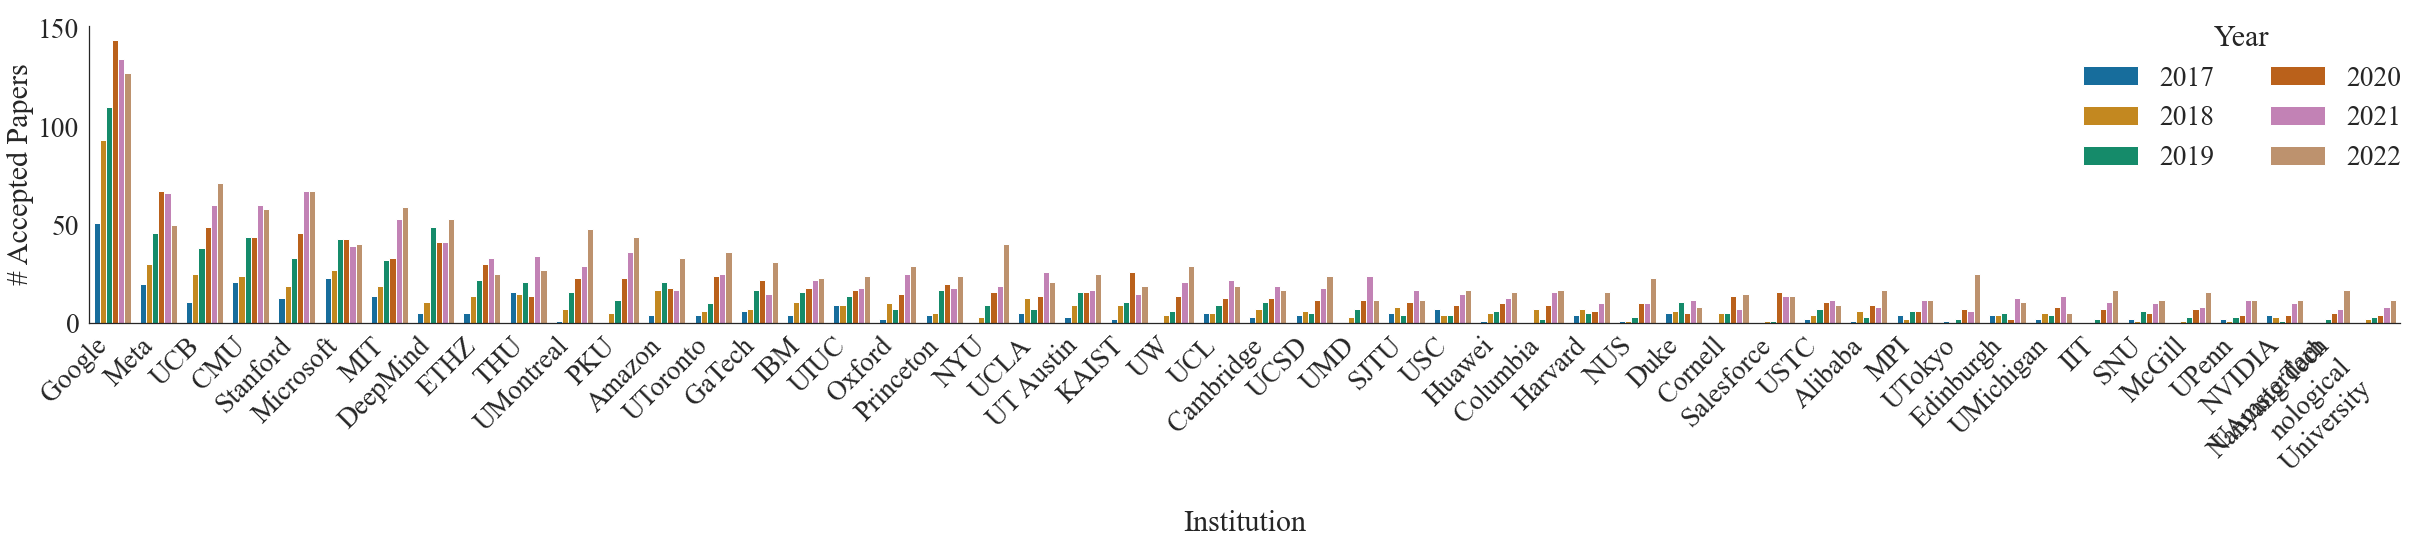

In [1669]:
import textwrap
matplotlib.rc('text', usetex=False)

plt_ins = int_total.ins_root.values[:100]
plt_dat = ins_acc_per_year[ins_acc_per_year.ins_root.isin(plt_ins[:50])]
plt_dat=plt_dat.rename({'year':'Year'},axis=1)
plt_dat['Year']=plt_dat['Year'].astype(int)
# plt_dat['Year']=pd.Categorical(plt_dat['Year'],range(2017,2023))
ax = sns.catplot(data=plt_dat,
                  x='ins_root',y='per_year_cnt',
                 hue='Year',kind="bar",
                 height=8, aspect=4, 
                 #              log_scale=(False,True),
            )
ax.set(xlabel=r'Institution', 
       ylabel=r'# Accepted Papers')
ax.set_xticklabels([
    textwrap.fill(label, 12)
    for label in plt_ins[:50]]    
    ,rotation=45,ha='right')

sns.move_legend(ax,loc=1,ncol=2)

plt.tight_layout()
# plt.savefig('./figs/accepted_institutions.png',bbox_inches='tight')
# plt.savefig('./figs/accepted_institutions.pdf',bbox_inches='tight')





In [230]:
sns.set(font_scale=2.5,)

sns.set_style("white")
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette("colorblind")


## arXiv before review ends?

In [1670]:
sub_arx_time = dataloader("sub_arx_time")

getter
venues
submission_arxiv


## Author per-year citation

In [1674]:
author_full = dataloader('author_full')

<AxesSubplot:xlabel='author_year_citation', ylabel='Count'>

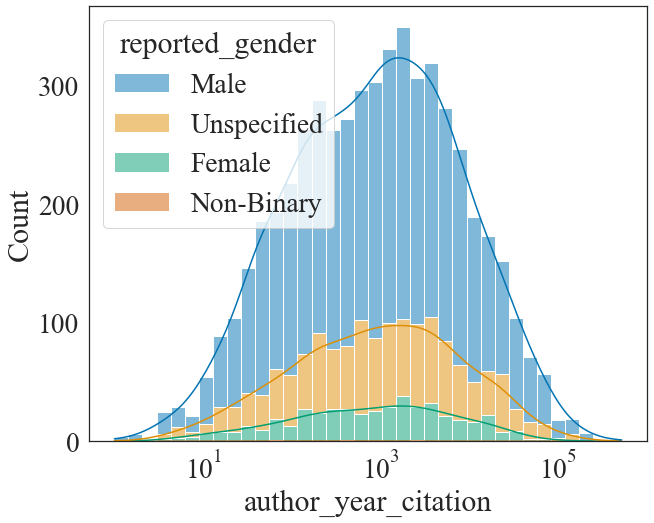

In [1678]:
sns.histplot(data=(author_full[['author_id','year','author_year_citation']]
 .drop_duplicates()
 .dropna()
 .sort_values('author_year_citation',ascending=False)
 .reset_index(drop=True)
 .query('year==2022')
).merge(author_gender), x='author_year_citation',hue='reported_gender',
 multiple='stack', kde=True,
             log_scale=(True,False)
            )

## P(Accept | Rating)

In [220]:
author_full = dataloader('author_full')
sub_arx_time = dataloader('sub_arx_time')
sub_reviews = dataloader('sub_reviews')

In [221]:
author_full = author_full.sort_values([ 'ins_per_year_rank'],ascending=True)

# author may have multiple affiliation at a time
# use the one that ranks better
author_full = \
    author_full.drop_duplicates(['author_id','submission_id','year'], keep='first')


In [222]:
author_rev = author_full.merge(
    sub_reviews,
).groupby(['submission_id','author_id']).agg({
    'year':'first',
    'rating_int':'mean',
    'author_year_citation':'max',
    'decision':'first',
    'full_decision': 'first',
    'binary_decision':'first',
    'confidence_int':'mean',
    'sentiment':'mean'
}).reset_index()

### Author-review

In [1538]:
matplotlib.rc('text', usetex=True)

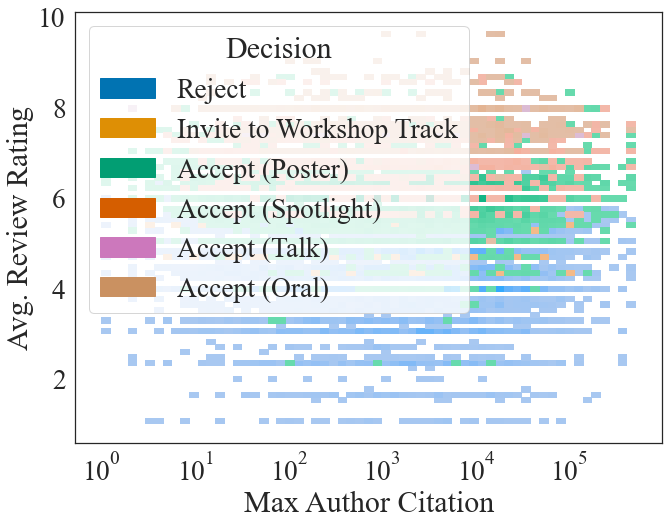

In [1781]:
ax = sns.histplot(data=author_rev,
            x='author_year_citation',y='rating_int',hue='full_decision',
                  hue_order=['Accept (Oral)', 'Accept (Talk)', 'Accept (Spotlight)',
                    'Accept (Poster)','Invite to Workshop Track','Reject', ][::-1],
             log_scale=(True,False)
)
sns.move_legend(ax, loc=2,title='Decision')

ax.set(xlabel='Max Author Citation', 
       ylabel='Avg. Review Rating')
plt.tight_layout()
# plt.savefig('./figs/hist_rating_citation.png',bbox_inches='tight')
# plt.savefig('./figs/hist_rating_citation.pdf',bbox_inches='tight')

## Acc prob

In [378]:
dataloader.flush_table_cache('author_grp')

In [379]:
author_grp = dataloader('author_grp')
sub_reviews_agg = dataloader('sub_reviews_agg')

In [380]:
author_grp=utils.get_log_col(author_grp, ['ins_rank_min', 'ins_rank_avg', 'ins_rank_max',
                               'author_cite_max', 'author_cite_avg','author_cite_min'
                              ])

In [381]:
# check summary
acc_rej_df = (sub_reviews_agg.assign(acc=sub_reviews['binary_decision'],
                                 rej=sub_reviews['binary_decision'],
                                    n=0)
    .groupby("rating_avg").agg({
            'acc': lambda grp: (grp==1).sum(),
            'rej': lambda grp: (grp==0).sum(),
            'n': lambda grp: grp.count(),
    })
).reset_index()
acc_rej_df['ratio'] = acc_rej_df['acc'] / acc_rej_df['rej']

# acc_rej_df.assign(cover=acc_rej_df['n']/8538)[(acc_rej_df.acc!=0)
#     &(acc_rej_df.rej!=0)]#.query("rating_int.between(5,6.75)")#.sum()

## P(Acc|Rating) ~ author citation

In [387]:
plt_dat = sub_reviews_agg.merge(author_grp)
plt_dat['Decision'] = plt_dat['full_decision']
plt_dat=plt_dat.replace({"Decision": {
    'Invite to Workshop Track': 'Reject',
    'Accept (Poster)': 'Poster',
    'Accept (Spotlight)': 'Spotlight',
    'Accept (Oral)': 'Oral',
    'Accept (Talk)': 'Oral',
    
},})

In [392]:
plt_dat['AnyFemale'] = plt_dat['fst_perceived_f'].apply(lambda x : 'Female Lead Author' if x else 'N')
plt_dat['Binary Decision'] = plt_dat['Decision'].apply(lambda x : x if x == 'Reject' else 'Accept')

### Geo

In [395]:
plt_dat=(plt_dat
         .merge((domain_per_year.groupby(['submission_id'])
                    .agg({'iso_a3':pd.Series.mode})
                    .reset_index()
                    .explode('iso_a3')
                ), on='submission_id')
         .assign(NA=lambda x : x.iso_a3.isin(['USA']) )
)

In [396]:
plt_geo_dat=(plt_dat
              .assign(acc_prob=lambda x : x.binary_decision, n=0)
              .groupby(['rating_avg','NA'])
              .agg({
    'acc_prob': lambda grp: (grp==1).sum()*1. / grp.shape[0],
    'n': lambda grp: grp.shape[0],
    
 })
 .reset_index()
)
plt_geo_dat['std']=plt_geo_dat.apply(
    lambda s : np.sqrt(s['acc_prob']*(1-s['acc_prob'])/s['n']),
    axis=1
)

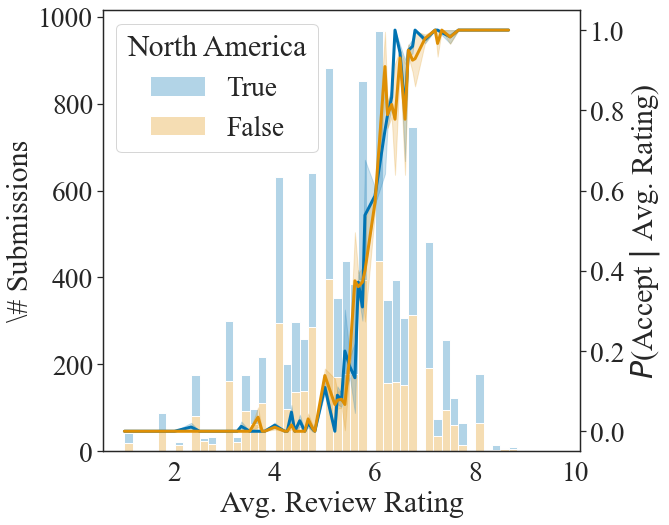

In [398]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
dt = (plt_geo_dat[plt_geo_dat.n>3]
                .rename({'rating_avg':'rating',
                        'acc_prob': 'pacc'},axis=1)
                  )
sns.lineplot(data=dt,
        x='rating', y='pacc', 
             hue='NA', hue_order=[True,False],
             legend=None,
        lw=3,ax=ax2,
)


for fidx, f in enumerate([True, False]):
    dtt = dt.query(f"NA=={f}")
    ax2.fill_between(dtt['rating'], 
                 dtt['pacc']-dtt['std'],
                 dtt['pacc']+dtt['std'],  color=f"C{fidx}",alpha=0.2)


sns.histplot(data=plt_dat[
            ~plt_dat.rating_avg.isna()].rename({'rating_avg':'rating',
                'NA':'North America'},axis=1),
             x='rating',
                hue='North America',alpha=0.3,hue_order=[True,False],
                  multiple='stack',ax=ax,
                 )
ax.set(xlabel='Avg. Review Rating', 
       ylabel=r'\# Submissions')
ax2.set(xlabel='Avg. Review Rating', 
       ylabel=r'$P$(Accept $|$ Avg. Rating)')

plt.tight_layout()
plt.savefig('./figs/hist_rev_acc_NA.png',bbox_inches='tight')
plt.savefig('./figs/hist_rev_acc_NA.pdf',bbox_inches='tight')

## Gender

In [250]:
plt_cite_dat=(plt_dat
              .assign(acc_prob=lambda x : x.binary_decision, n=0)
              .groupby(['rating_avg','top_author'])
              .agg({
    'acc_prob': lambda grp: (grp==1).sum()*1. / grp.shape[0],
    'n': lambda grp: grp.shape[0],
    
 })
 .reset_index()
)
plt_cite_dat['std']=plt_cite_dat.apply(
    lambda s : np.sqrt(s['acc_prob']*(1-s['acc_prob'])/s['n']),
    axis=1
)

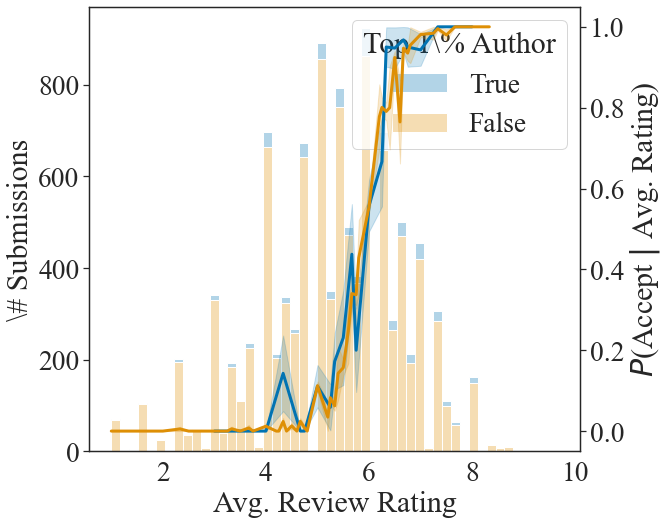

In [251]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
dt = (plt_cite_dat[plt_cite_dat.n>10]
                .rename({'rating_avg':'rating',
                        'acc_prob': 'pacc'},axis=1)
                  )
sns.lineplot(data=dt,
        x='rating', y='pacc', 
             hue='top_author', hue_order=[True,False],
             legend=None,
        lw=3,ax=ax2,
)


for fidx, f in enumerate([True, False]):
    dtt = dt.query(f"top_author=={f}")
    ax2.fill_between(dtt['rating'], 
                 dtt['pacc']-dtt['std'],
                 dtt['pacc']+dtt['std'],  color=f"C{fidx}",alpha=0.2)


sns.histplot(data=plt_dat[
            ~plt_dat.rating_avg.isna()].rename({'rating_avg':'rating',
                'top_author':'Top 1\% Author'},axis=1),
             x='rating',
                hue='Top 1\% Author',alpha=0.3,hue_order=[True,False],
                  multiple='stack',ax=ax,
                 )
ax.set(xlabel='Avg. Review Rating', 
       ylabel=r'\# Submissions')
ax2.set(xlabel='Avg. Review Rating', 
       ylabel=r'$P$(Accept $|$ Avg. Rating)')

plt.tight_layout()
# plt.savefig('./figs/hist_rev_acc_topauthor.png',bbox_inches='tight')
# plt.savefig('./figs/hist_rev_acc_topauthor.pdf',bbox_inches='tight')

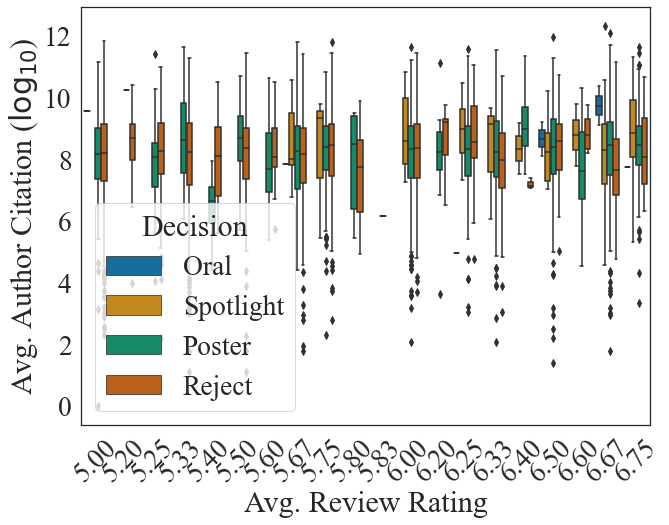

In [1889]:
plt_x = sorted(plt_dat[plt_dat.rating_avg.between(5,6.75)]
               .rating_avg.unique()
              )
ax = sns.boxplot(data=(plt_dat[
                    plt_dat.rating_avg.isin(plt_x)
                ]).query("author_cite_avg_log>=0"),
                  x='rating_avg',
        hue='Decision', y='author_cite_avg_log',
                 hue_order=['Oral','Spotlight','Poster','Reject'],

                 )

ax.set_xticklabels([
    textwrap.fill(f"{x:.2f}", 12)
    for x in plt_x]    
    ,rotation=45,ha='center')
ax.set(xlabel=r'Avg. Review Rating', 
       ylabel=r'Avg. Author Citation ($\log_{10}$)')
plt.tight_layout()
# plt.savefig('./figs/box_rev_avgcite.png',bbox_inches='tight')
# plt.savefig('./figs/box_rev_avgcite.pdf',bbox_inches='tight')

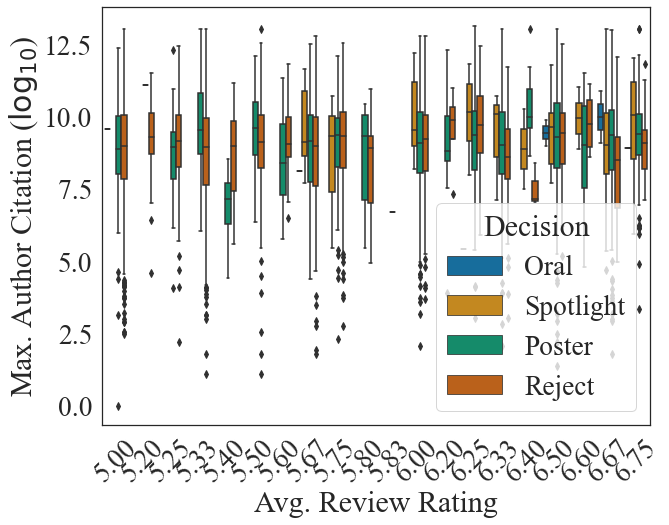

In [1891]:
plt_x = sorted(plt_dat[plt_dat.rating_avg.between(5,6.75)]
               .rating_avg.unique())
ax = sns.boxplot(data=(plt_dat[
                    plt_dat.rating_avg.isin(plt_x)
                ]),
                  x='rating_avg',
        hue='Decision', y='author_cite_max_log',
                 hue_order=['Oral','Spotlight','Poster','Reject'],
                 )

ax.set_xticklabels([
    textwrap.fill(f"{x:.2f}", 12)
    for x in plt_x]    
    ,rotation=45,ha='center')
ax.set(xlabel=r'Avg. Review Rating', 
       ylabel=r'Max. Author Citation ($\log_{10}$)')
plt.tight_layout()
# plt.savefig('./figs/box_rev_maxcite.png',bbox_inches='tight')
# plt.savefig('./figs/box_rev_maxcite.pdf',bbox_inches='tight')

### hist of arXiv

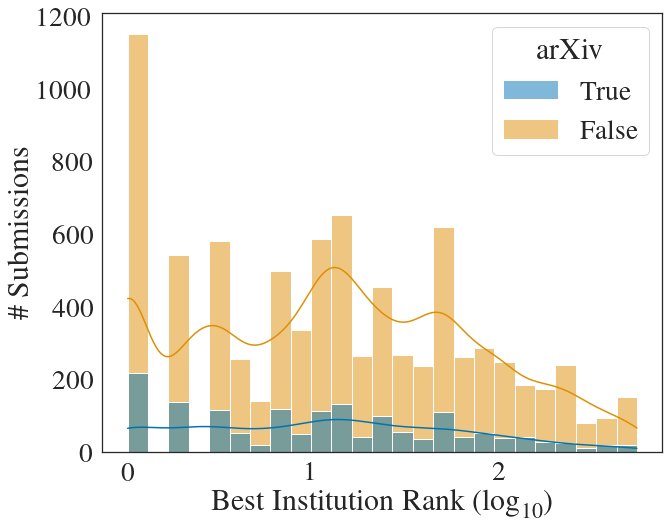

In [680]:

ax = sns.histplot(data=plt_dat.rename({'arxiv_first':'arXiv'},axis=1),
                  x='log_rank', hue='arXiv', hue_order=[True,False],
                  kde=True, log_scale=(False,False))

ax.set(xlabel='Best Institution Rank ($\log_{10}$)', 
       ylabel='\# Submissions')
plt.tight_layout()
plt.savefig('./figs/hist_sub_arxiv.png',bbox_inches='tight')
plt.savefig('./figs/hist_sub_arxiv.pdf',bbox_inches='tight')

### P(Acc|Rating) ~ arxiv

In [366]:
plt_arx_dat=(plt_dat.groupby(['rating_int','arxiv_first']).agg({
    'Decision': lambda grp: (grp=='Accept').sum()*1. / grp.shape[0],
    'review_len': lambda grp: grp.shape[0],
    
 })
 .reset_index()
 .rename({'Decision':'acc_prob',
          'review_len':'n',
         },axis=1)

)
plt_arx_dat['std']=plt_arx_dat.apply(
    lambda s : np.sqrt(s['acc_prob']*(1-s['acc_prob'])/s['n']),
    axis=1
)

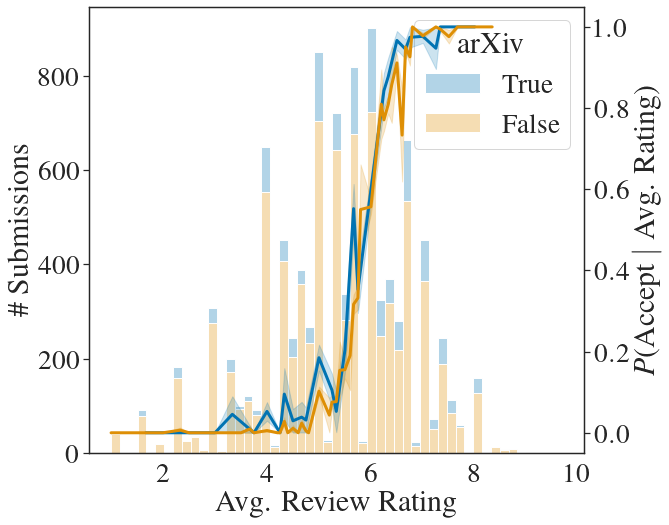

In [372]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
dt = (plt_arx_dat[plt_arx_dat.n>10]
                .rename({'rating_int':'rating',
                        'acc_prob': 'pacc'},axis=1)
                  )
sns.lineplot(data=dt,
        x='rating', y='pacc', 
             hue='arxiv_first', hue_order=[True,False],
             legend=None,
        lw=3,ax=ax2,
)


for fidx, f in enumerate([True, False]):
    dtt = dt.query(f"arxiv_first=={f}")
    ax2.fill_between(dtt['rating'], 
                 dtt['pacc']-dtt['std'],
                 dtt['pacc']+dtt['std'],  color=f"C{fidx}",alpha=0.2)


sns.histplot(data=plt_dat[
            ~plt_dat.rating_int.isna()].rename({'rating_int':'rating',
                'arxiv_first':'arXiv'},axis=1),
             x='rating',
                hue='arXiv',alpha=0.3,hue_order=[True,False],
                  multiple='stack',ax=ax,
                 )
ax.set(xlabel='Avg. Review Rating', 
       ylabel=r'\# Submissions')
ax2.set(xlabel='Avg. Review Rating', 
       ylabel=r'$P$(Accept $|$ Avg. Rating)')

plt.tight_layout()
plt.savefig('./figs/hist_rev_acc_arxiv.png',bbox_inches='tight')
plt.savefig('./figs/hist_rev_acc_arxiv.pdf',bbox_inches='tight')

### P(Acc|Rating) ~ Inst

In [1545]:
plt_ins_dat=(plt_dat
             .groupby(['rating_int','top_inst']).agg({
    'Decision': lambda grp: (grp=='Accept').sum()*1. / grp.shape[0],
    'review_len': lambda grp: grp.shape[0],
    
 })
 .reset_index()
 .rename({'Decision':'acc_prob',
          'review_len':'n',
         },axis=1)

)
plt_ins_dat['std']=plt_ins_dat.apply(
    lambda s : np.sqrt(s['acc_prob']*(1-s['acc_prob'])/s['n']),
    axis=1
)

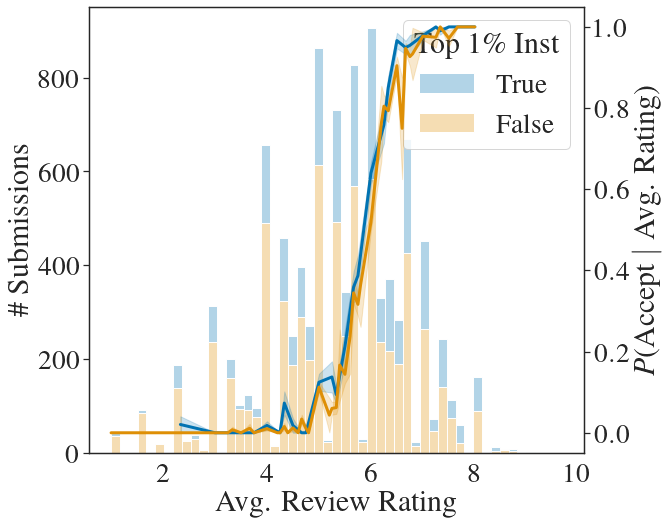

In [675]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
dt = (plt_ins_dat[plt_ins_dat.n>10]
                .rename({'rating_int':'rating',
                        'acc_prob': 'pacc'},axis=1)
                  )
sns.lineplot(data=dt,
        x='rating', y='pacc', 
             hue='top_inst', hue_order=[True,False],
             legend=None,
        lw=3,ax=ax2,
)


for fidx, f in enumerate([True, False]):
    dtt = dt.query(f"top_inst=={f}")
    ax2.fill_between(dtt['rating'], 
                 dtt['pacc']-dtt['std'],
                 dtt['pacc']+dtt['std'],  color=f"C{fidx}",alpha=0.2)


sns.histplot(data=plt_dat[
            ~plt_dat.rating_int.isna()].rename({'rating_int':'rating',
                'top_inst':'Top 1\% Inst'},axis=1),
             x='rating',
                hue='Top 1\% Inst',alpha=0.3,hue_order=[True,False],
                  multiple='stack',ax=ax,
                 )
ax.set(xlabel='Avg. Review Rating', 
       ylabel=r'\# Submissions')
ax2.set(xlabel='Avg. Review Rating', 
       ylabel=r'$P$(Accept $|$ Avg. Rating)')

plt.tight_layout()
plt.savefig('./figs/hist_rev_acc_topinst.png',bbox_inches='tight')
plt.savefig('./figs/hist_rev_acc_topinst.pdf',bbox_inches='tight')

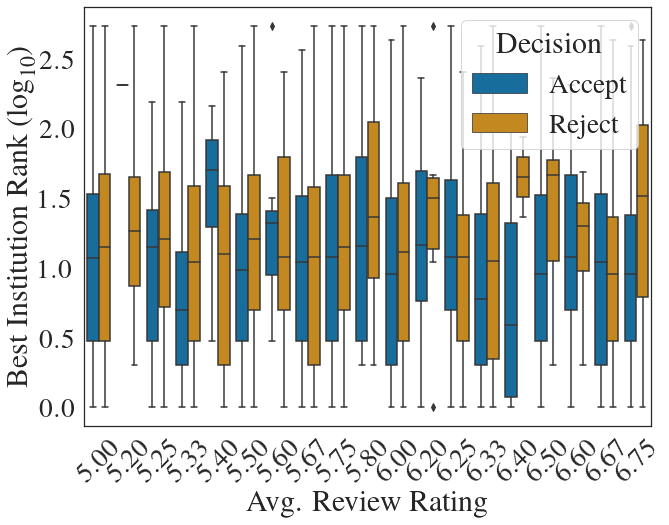

In [1547]:
plt_x = sorted(plt_dat[plt_dat.rating_int.between(5.,6.75)]
               .rating_int.unique())
ax = sns.boxplot(data=(plt_dat[
                    plt_dat.rating_int.isin(plt_x)
                ]),#.query("Decision=='Accept'"),
                  x='rating_int',
        hue='Decision', y='log_rank',
                 )

ax.set_xticklabels([
    textwrap.fill(f"{x:.2f}", 12)
    for x in plt_x]    
    ,rotation=45,ha='center')
ax.set(xlabel=r'Avg. Review Rating', 
       ylabel=r'Best Institution Rank ($\log_{10}$)')
plt.tight_layout()
plt.savefig('./figs/box_rev_rank.png',bbox_inches='tight')
plt.savefig('./figs/box_rev_rank.pdf',bbox_inches='tight')

### P(Acc|Rating) ~ Year

In [178]:
plt_conf_dat=(plt_dat.groupby(['rating_int','Year']).agg({
    'Decision': lambda grp: (grp=='Accept').sum()*1. / grp.shape[0],
    'review_len': lambda grp: grp.shape[0],
    
 })
 .reset_index()
 .rename({'Decision':'acc_prob',
          'review_len':'n',
          'reported_f':'Has Female Author',
         },axis=1)

)
plt_conf_dat['std']=plt_conf_dat.apply(
    lambda s : np.sqrt(s['acc_prob']*(1-s['acc_prob'])/s['n']),
    axis=1
)

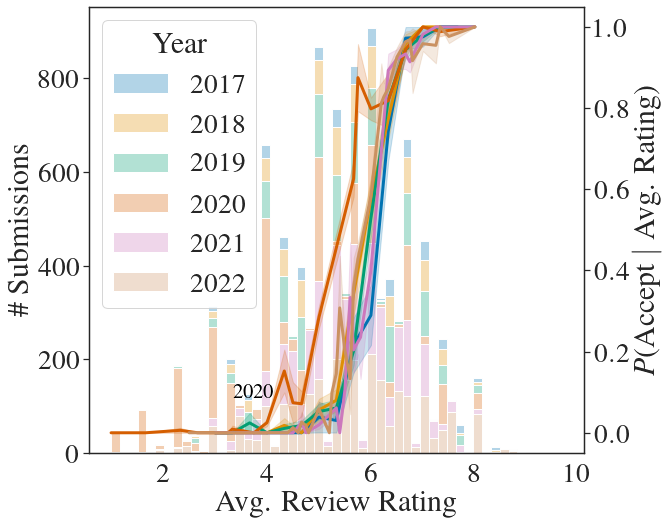

In [1461]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
dt = (plt_conf_dat[plt_conf_dat.n>10]
                .rename({'rating_int':'rating',
                        'acc_prob': 'pacc'},axis=1)
                  )
sns.lineplot(data=dt,
        x='rating', y='pacc', 
             hue='Year',
             legend=None,
     lw=3,#markers=True, ms=10,#color='C3',
        ax=ax2,
)
for yidx, yr in enumerate(range(2017,2023)):
    dtt = dt.query(f"Year=={yr}")
    ax2.fill_between(dtt['rating'], 
                 dtt['pacc']-dtt['std'],
                 dtt['pacc']+dtt['std'],  color=f"C{yidx}",alpha=0.2)


sns.histplot(data=plt_dat[
            ~plt_dat.rating_int.isna()].rename({'rating_int':'rating',
                },axis=1),
             x='rating',
                hue='Year',alpha=0.3,
                  multiple='stack',ax=ax,
                 )
ax.set(xlabel='Avg. Review Rating', 
       ylabel=r'\# Submissions')
ax2.set(xlabel='Avg. Review Rating', 
       ylabel=r'$P$(Accept $|$ Avg. Rating)')
ax.text(3.75,120,r"$2020$",
    rotation=0, size='x-small', 
     color='black', weight='bold',
    horizontalalignment='center', 
)

plt.tight_layout()
plt.savefig('./figs/hist_rev_acc_y.png',bbox_inches='tight')
plt.savefig('./figs/hist_rev_acc_y.pdf',bbox_inches='tight')

### P(Acc|Rating) ~ gender

In [423]:
plt_g_dat=(plt_dat
              .assign(acc_prob=lambda x : x.binary_decision, n=0)
              .groupby(['rating_avg','any_perceived_f'])
              .agg({
    'acc_prob': lambda grp: (grp==1).sum()*1. / grp.shape[0],
    'n': lambda grp: grp.shape[0],
    
 })
 .reset_index()
)
plt_g_dat['std']=plt_g_dat.apply(
    lambda s : np.sqrt(s['acc_prob']*(1-s['acc_prob'])/s['n']),
    axis=1
)

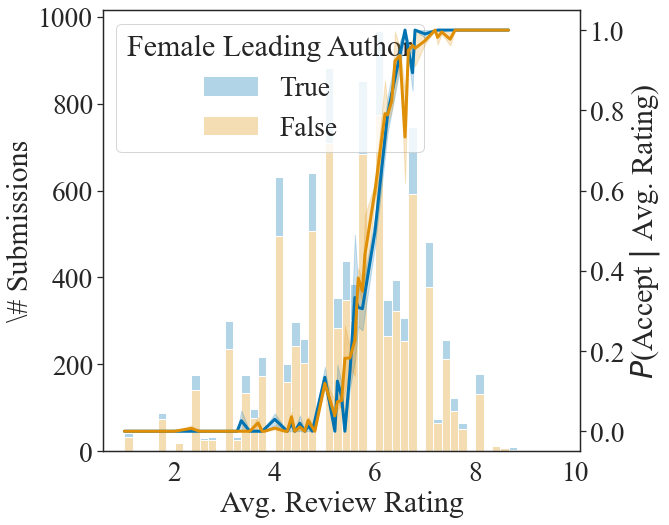

In [429]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
dt = (plt_g_dat[plt_g_dat.n>3]
                .rename({'rating_avg':'rating',
                        'acc_prob': 'pacc'},axis=1)
                  )
sns.lineplot(data=dt,
        x='rating', y='pacc', 
             hue='any_perceived_f', hue_order=[True,False],
             legend=None,
        lw=3,ax=ax2,
)


for fidx, f in enumerate([True, False]):
    dtt = dt.query(f"any_perceived_f=={f}")
    ax2.fill_between(dtt['rating'], 
                 dtt['pacc']-dtt['std'],
                 dtt['pacc']+dtt['std'],  color=f"C{fidx}",alpha=0.2)


sns.histplot(data=plt_dat[
            ~plt_dat.rating_avg.isna()].rename({'rating_avg':'rating',
                'any_perceived_f':'Female Leading Author'},axis=1),
             x='rating',
                hue='Female Leading Author',alpha=0.3,hue_order=[True,False],
                  multiple='stack',ax=ax,
                 )
sns.move_legend(ax,2)
ax.set(xlabel='Avg. Review Rating', 
       ylabel=r'\# Submissions')
ax2.set(xlabel='Avg. Review Rating', 
       ylabel=r'$P$(Accept $|$ Avg. Rating)')



plt.tight_layout()
plt.savefig('./figs/hist_rev_acc_lead.png',bbox_inches='tight')
plt.savefig('./figs/hist_rev_acc_lead.pdf',bbox_inches='tight')

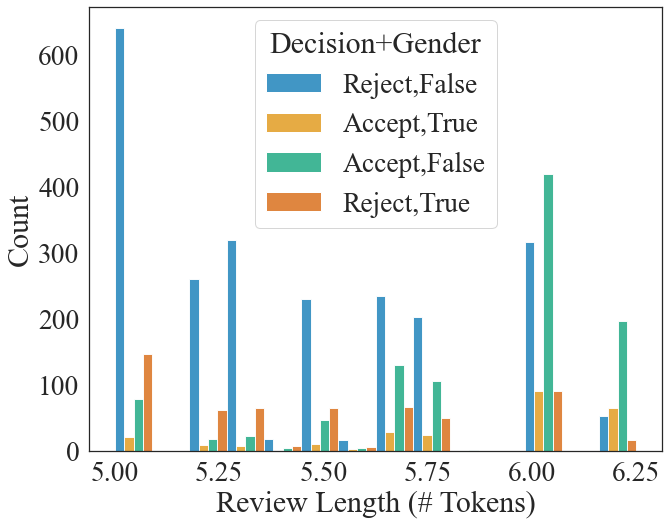

In [174]:
fig, ax = plt.subplots()
ax = sns.histplot(data=(plt_dat[
                    plt_dat.rating_int.between(5,6.25)
                ]), x='rating_int',

                  hue='Decision+Gender',
                  multiple='dodge'
#             kde=True, 
#                   log_scale=(True,False)
                 )

ax.set(xlabel='Review Length (# Tokens)', 
       ylabel='Count')
plt.tight_layout()
# plt.savefig('./figs/hist_sub_genr.png',bbox_inches='tight')
# plt.savefig('./figs/hist_sub_genr.pdf',bbox_inches='tight')

## Histograms

### Length

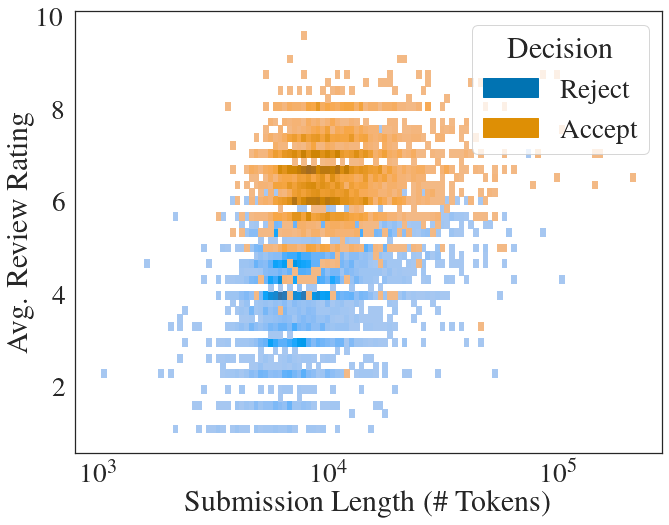

In [594]:
ax = sns.histplot(data=plt_dat, x='input_len',
                  y='rating_int',
                  hue='Decision',
            kde=True, log_scale=(True,False))

ax.set(xlabel='Submission Length (\# Tokens)', 
       ylabel='Avg. Review Rating')
plt.tight_layout()
plt.savefig('./figs/hist_sub_rev_rating.png',bbox_inches='tight')
plt.savefig('./figs/hist_sub_rev_rating.pdf',bbox_inches='tight')

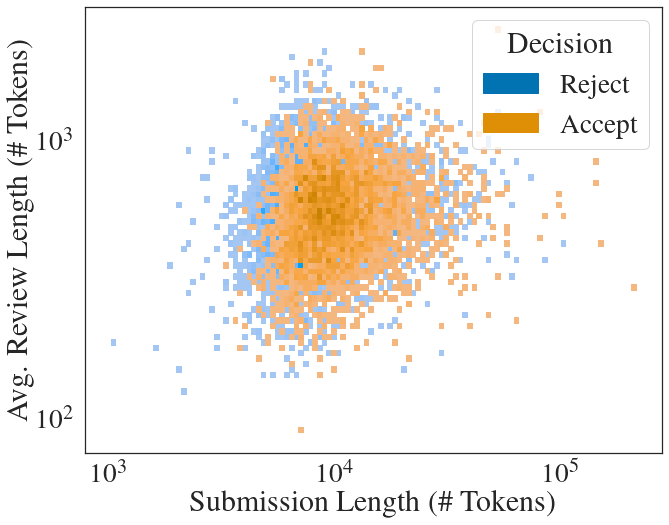

In [591]:
ax = sns.histplot(data=plt_dat, x='input_len',
                  y='review_len',
#                   hue='Decision+Gender',
                  hue='Decision',
            kde=True, log_scale=(True,True))

ax.set(xlabel='Submission Length (\# Tokens)', 
       ylabel='Avg. Review Length (\# Tokens)')
plt.tight_layout()
plt.savefig('./figs/hist_sub_rev_len.png',bbox_inches='tight')
plt.savefig('./figs/hist_sub_rev_len.pdf',bbox_inches='tight')

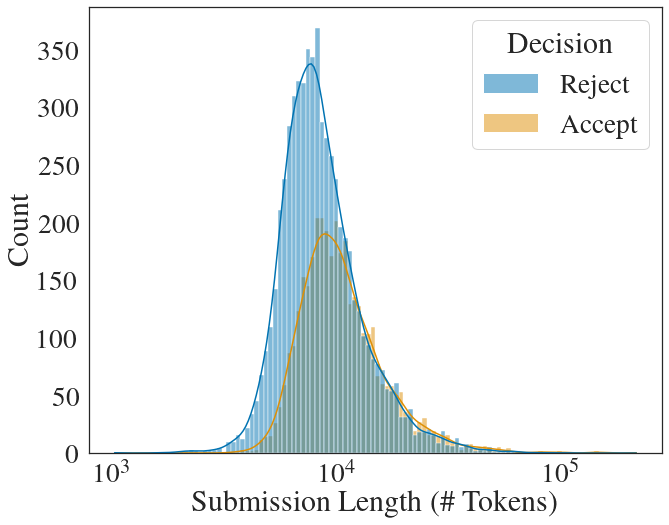

In [188]:

ax = sns.histplot(data=plt_dat, x='input_len',

                  hue='Decision',
            kde=True, log_scale=(True,False))

ax.set(xlabel='Submission Length (\# Tokens)', 
       ylabel='Count')
plt.tight_layout()
plt.savefig('./figs/hist_sub_len.png',bbox_inches='tight')
plt.savefig('./figs/hist_sub_len.pdf',bbox_inches='tight')

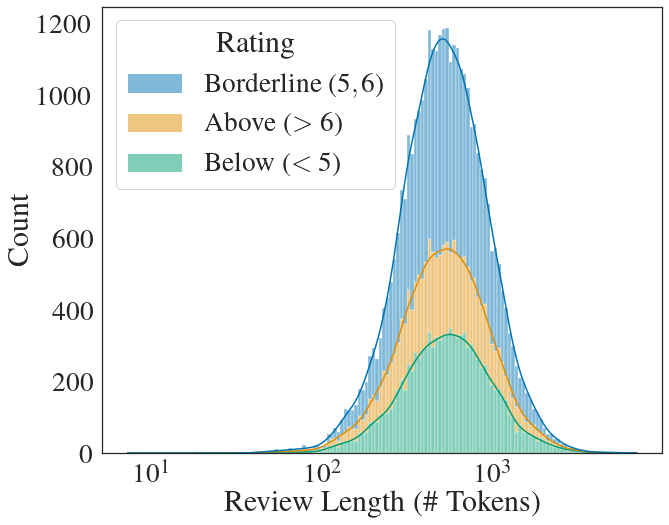

In [588]:

ax = sns.histplot(data=(iclr_dataset[iclr_dataset.input_len>100]
                        .rename({'decision':'Decision', 'type':'Rating'},axis=1)
                        .replace({'Rating':{
                            'borderline': 'Borderline ($5,6$)',
                            'positive': 'Above ($>6$)',
                            'negative': 'Below ($<5$)'
                        }})
                       ), x='review_len',
#                   y='review_len',
                  hue='Rating',multiple='stack',
            kde=True, log_scale=(True,False))

ax.set(xlabel='Review Length (\# Tokens)', 
       ylabel='Count')
# ax.legend(['Borderline','Above','Below'], title='Review Rating')
plt.tight_layout()
plt.savefig('./figs/hist_rev_len.png',bbox_inches='tight')
plt.savefig('./figs/hist_rev_len.pdf',bbox_inches='tight')

## Authors

#### author stats

In [236]:
author_full.reported_gender.unique()

array(['Unspecified', 'Male', 'Female', 'Non-Binary'], dtype=object)

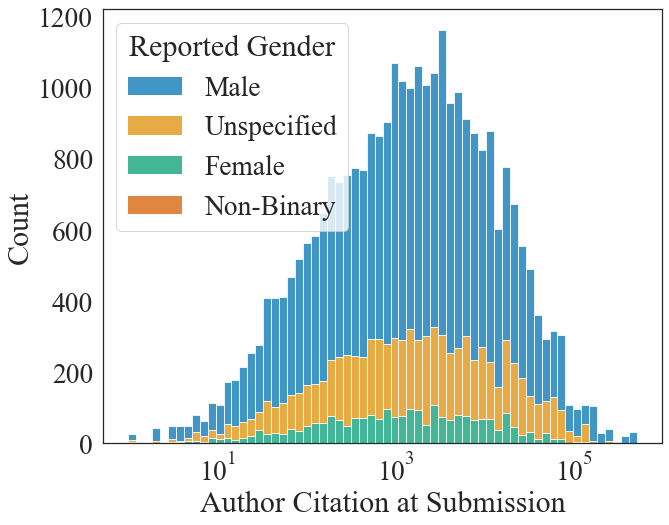

In [247]:

ax = sns.histplot(
    x='author_year_citation',
#     y='citedby',
    data=author_full,
    hue='reported_gender',
    log_scale=(True,False),
    multiple="stack",
    hue_order=['Male', 'Unspecified','Female','Non-Binary'],
#     kde=True,
#     element='poly',
#     fill=False
)
ax.set(xlabel='Author Citation at Submission', 
       ylabel='Count')
sns.move_legend(ax,0,title='Reported Gender', 
#            labels=['Male', 'Unspecified','Female','Non-Binary'],
          )
plt.tight_layout()
plt.savefig('./figs/hist_author_citation.png',bbox_inches='tight')
plt.savefig('./figs/hist_author_citation.pdf',bbox_inches='tight')

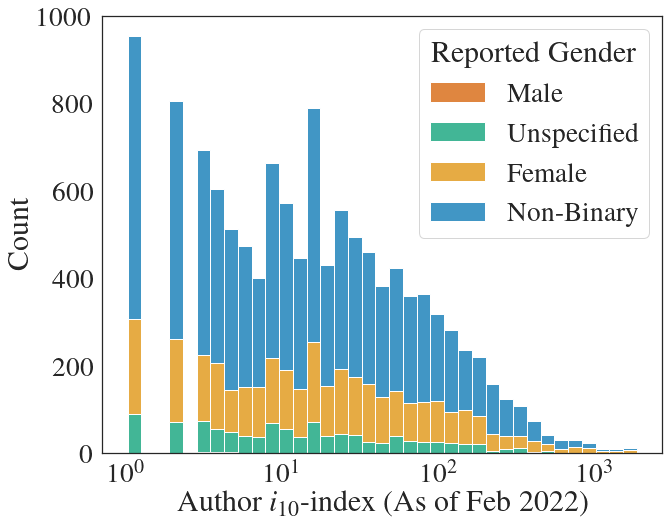

In [1434]:

ax = sns.histplot(
    x='i10index',
#     y='citedby',
    data=gs_author_merge[gs_author_merge.i10index>0],
    hue='reported_gender',
    log_scale=(True,False),
    multiple="stack",
#     kde=True,
#     element='poly',
#     fill=False
)
ax.set(xlabel='Author $i_{10}$-index (As of Feb 2022)', 
       ylabel='Count')
plt.legend(title='Reported Gender', 
           loc=1, 
           labels=['Male', 'Unspecified','Female','Non-Binary'])
plt.tight_layout()
plt.savefig('./figs/hist_author_i10index.png',bbox_inches='tight')
plt.savefig('./figs/hist_author_i10index.pdf',bbox_inches='tight')

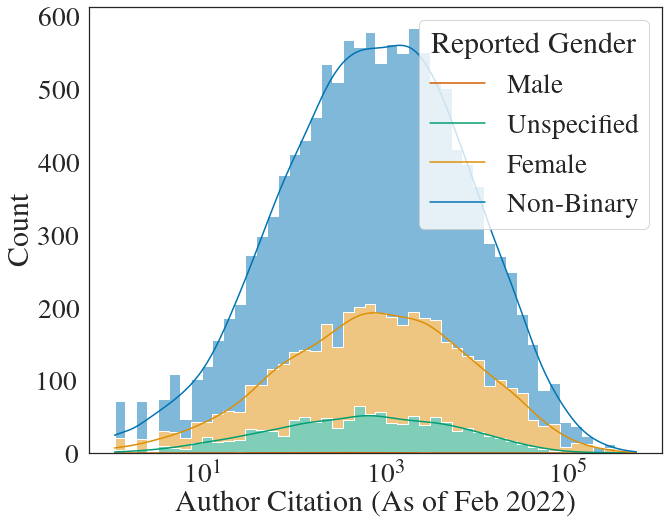

In [598]:
ax=sns.histplot(
    x='citedby',
    data=gs_author_merge,
    hue='reported_gender',
    log_scale=True,
    multiple="stack",
    element='step',
    kde=True
#     fill=False
)
ax.set(xlabel='Author Citation (As of Feb 2022)', 
       ylabel='Count')
plt.legend(title='Reported Gender', 
           loc=1, 
           labels=['Male', 'Unspecified','Female','Non-Binary'])
plt.tight_layout()
plt.savefig('./figs/author_citation_hist.png', bbox_inches='tight')
plt.savefig('./figs/author_citation_hist.pdf', bbox_inches='tight')

#### fluency

In [1490]:
sub_sentiment.mean_sentiment=sub_sentiment.mean_sentiment.astype(float)

In [1491]:
(matched_sub.groupby("primary_category")
 .submission_id.nunique()
 .sort_values(ascending=False)
 .head(10)
)


primary_category
cs.LG      1632
cs.CV       360
cs.CL       195
stat.ML     156
cs.AI        46
math.OC      23
cs.NE        23
cs.SD        14
eess.AS      12
cs.CR        11
Name: submission_id, dtype: int64

In [1492]:
sub_arxiv_fl = (sub_sentiment[['submission_id','mean_sentiment']]
 .merge(matched_sub[['submission_id','primary_category']])
 .merge(sub_main_keyword)
 .rename({'mean_sentiment':'fluency'},axis=1)
)
sub_arxiv_fl.fluency=sub_arxiv_fl.fluency.astype(float)

In [1493]:
sub_arxiv_fl['cat'] = sub_arxiv_fl.primary_category.apply(
lambda s : s.split('.')[0])

In [1494]:
most_freq_kws = pd.DataFrame(sub_main_keyword
 .groupby('primary_keyword')
 .submission_id.nunique()
 .sort_values(ascending=False)
 .head(15)
).reset_index()

<AxesSubplot:xlabel='fluency', ylabel='Count'>

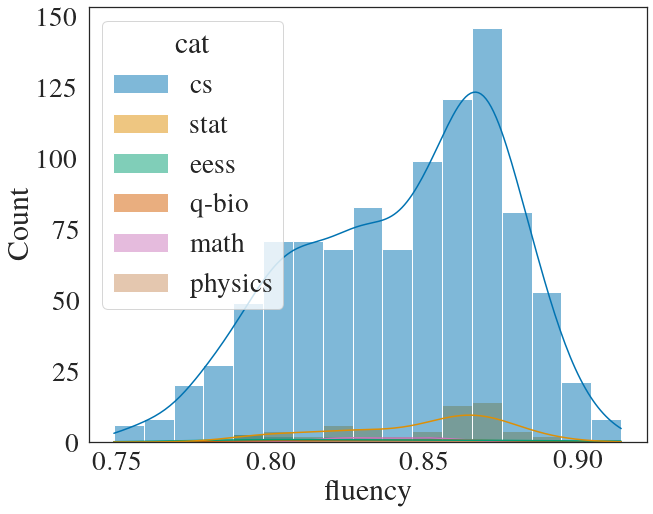

In [1495]:
sns.histplot(data=sub_arxiv_fl[
    sub_arxiv_fl.primary_keyword.isin(
        most_freq_kws.primary_keyword.values
    )], 
     x="fluency",
#      hue='primary_keyword',
             hue='cat',
     kde=True)


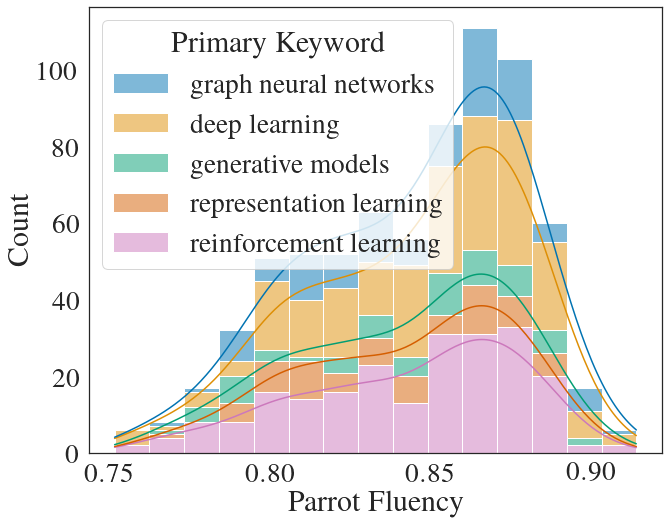

In [1497]:
ax = sns.histplot(data=(sub_arxiv_fl[
        sub_arxiv_fl.primary_keyword.isin(
            most_freq_kws.primary_keyword.values[:5]
        )].rename({'primary_keyword':'Primary Keyword'},axis=1)
     ),
     x="fluency",
             multiple="stack",
     hue='Primary Keyword',
#              hue='cat',
     kde=True)


ax.set(xlabel='Parrot Fluency', 
       ylabel='Count')
# plt.legend(title='Primary Keyword', 
#            loc=2, 
#            labels=most_freq_kws.primary_keyword.values[:5]
#           )
plt.tight_layout()
plt.savefig('./figs/prikwd_parrot.png',bbox_inches='tight')
plt.savefig('./figs/prikwd_parrot.pdf',bbox_inches='tight')

In [612]:
plt_cats= [ 'cs.LG', 'cs.CV', 'cs.CL', 'math.OC']

### Reviews

In [169]:
sub_reviews = (reviews[['id','forum','rating_int', 'confidence_int']]
 .rename({'forum':'submission_id'},axis=1)
 .merge(submissions[['submission_id','conf_year']])
 .merge((comment_sentiment[['id','rbt_sentiment_mean']]
         .rename({'rbt_sentiment_mean':'sentiment'},axis=1)
    ))
 .merge(decisions[['forum','decision']].rename(
        {'forum':'submission_id'},axis=1
     ))
 .replace({'decision':{
     'Accept (Poster)':'Accept',
     'Reject':'Reject', 
     'Accept (Spotlight)': 'Accept',
     'Accept (Oral)':'Accept',
       'Accept (Talk)':'Accept',
     'Invite to Workshop Track':'Reject', 
 }})
)

In [170]:
sub_reviews['sentiment']=sub_reviews['sentiment'].astype(float)
sub_reviews['rating_int']=\
    sub_reviews['rating_int'].astype(float).astype(int)
# sub_reviews['confidence_int']=\
#     sub_reviews['confidence_int'].astype(float).astype(int)
sub_reviews['n_reviews']=\
    sub_reviews.groupby('submission_id').id.transform('nunique')

In [171]:
(sub_reviews[['submission_id','n_reviews']]
 .drop_duplicates()
 .n_reviews
 .describe()
)

count    10297.000000
mean         3.468680
std          0.600129
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: n_reviews, dtype: float64

In [ ]:
# for rid, row in (plt_dat[~plt_dat.primary_keyword.isna()]
#                  .sample(20).iterrows()):

#     ax.text(row.x0+0.01, row.x1,  
#             row.primary_keyword,#+','+row.secondary_keyword,
#     horizontalalignment='left', 
#      size='xx-small', color='black', weight='light',
#             fontstretch='semi-condensed',
#            )





In [1076]:
sns.set(font_scale=2,)

sns.set_style("white")
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette("colorblind")


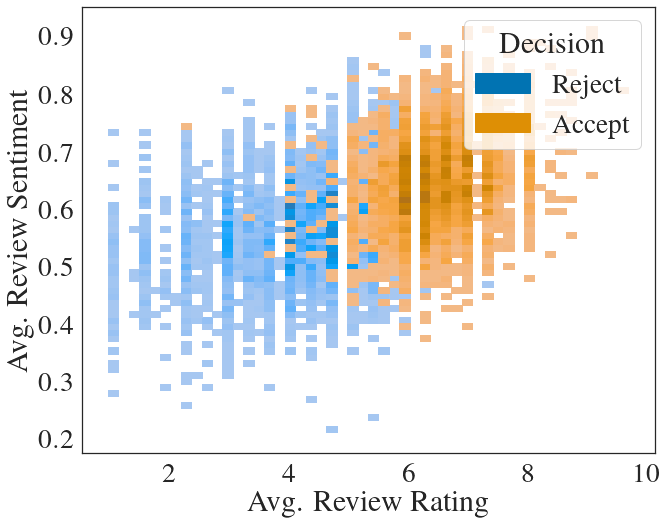

In [618]:
ax = sns.histplot(data=(sub_reviews
                  .rename({'decision':'Decision'},axis=1)
                  .groupby('submission_id')
                  .agg({
                      'rating_int':'mean',
                      'sentiment':'mean',
                      'Decision':'first'
                       
                       })
                 ),
            x='rating_int',y='sentiment',
                  palette='colorblind',
           hue='Decision')
ax.set(xlabel=r'Avg. Review Rating', 
       ylabel=r'Avg. Review Sentiment')
plt.tight_layout()
plt.savefig('./figs/rating_sentiment_decision.png',bbox_inches='tight')
plt.savefig('./figs/rating_sentiment_decision.pdf',bbox_inches='tight')

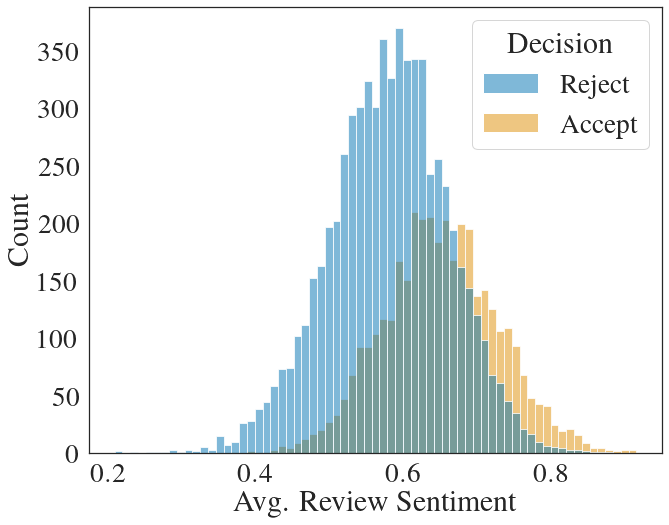

In [619]:
ax=sns.histplot((sub_reviews
              .rename({'decision':'Decision'},axis=1)
              .groupby('submission_id')
              .agg({
                  'rating_int':'mean',
                  'sentiment':'mean',
                  'Decision':'first'

                   })
             ),
             x='sentiment',
             hue='Decision')

ax.set(xlabel=r'Avg. Review Sentiment', 
       ylabel='Count')
plt.tight_layout()
plt.savefig('./figs/hist_sentiment_decision.png',bbox_inches='tight')
plt.savefig('./figs/hist_sentiment_decision.pdf',bbox_inches='tight')

In [788]:
(sub_reviews
    .rename({'decision':'Decision'},axis=1)
    .groupby('submission_id')
    .agg({
          'rating_int':'mean',
          'sentiment':'mean',
          'Decision':'first'
       })
 .reset_index()
 .query("Decision=='Accept'")
 .sort_values('rating_int')
)

,submission_id,rating_int,sentiment,Decision
8793,rJg76kStwH,2.333333,0.742618,Accept
2830,H1emfT4twB,3.333333,0.582936,Accept
8874,rJlWOj0qF7,3.666667,0.522710,Accept
1639,BJxkOlSYDH,4.000000,0.709523,Accept
6246,SyxIWpVYvr,4.000000,0.633933,Accept
...,...,...,...,...
6421,UH-cmocLJC,8.750000,0.791355,Accept
8392,r1Ue8Hcxg,9.000000,0.900962,Accept
7037,b-ny3x071E5,9.000000,0.659103,Accept
3462,Hk6kPgZA-,9.000000,0.911781,Accept


In [783]:
sub_review_by_rating = pd.DataFrame(sub_reviews
    .rename({'decision':'Decision'},axis=1)
    .groupby('submission_id')
    .agg({
          'rating_int':'mean',
          'sentiment':'mean',
          'Decision':'first'
       })
    .reset_index().assign(ndecision='Decision')
    .groupby(['rating_int','Decision'])
    .nunique().reset_index()
  )


In [811]:
sub_review_by_rating = pd.pivot(sub_review_by_rating,index='rating_int',columns='Decision',
         values='submission_id').reset_index()

        

In [829]:
(sub_review_by_rating[~(sub_review_by_rating.isna().any(axis=1))]
 .query("Accept >= 10 & Reject >= 10")
 .assign(n_total=lambda s : s['Accept'].sum()+s['Reject'].sum())
 .query("rating_int >=5 & rating_int <=6.75")
 .assign(p=lambda s : (s['Accept'].sum()+s['Reject'].sum()) / s['n_total'].iloc[0])
)

Decision,rating_int,Accept,Reject,n_total,p
36,5.000000,100.0,791.0,5806.0,0.921633
38,5.250000,26.0,294.0,5806.0,0.921633
39,5.333333,29.0,385.0,5806.0,0.921633
41,5.500000,56.0,295.0,5806.0,0.921633
43,5.666667,158.0,302.0,5806.0,0.921633
44,5.750000,117.0,236.0,5806.0,0.921633
45,5.800000,12.0,16.0,5806.0,0.921633
47,6.000000,513.0,411.0,5806.0,0.921633
49,6.250000,241.0,63.0,5806.0,0.921633
50,6.333333,291.0,73.0,5806.0,0.921633


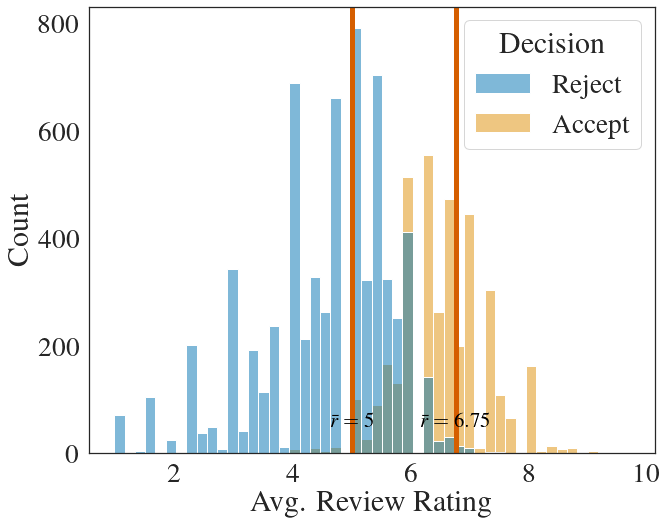

In [844]:
ax=sns.histplot((sub_reviews
              .rename({'decision':'Decision'},axis=1)
              .groupby('submission_id')
              .agg({
                  'rating_int':'mean',
                  'sentiment':'mean',
                  'Decision':'first'

                   })
             ),
             x='rating_int',
             hue='Decision')

ax.set(xlabel=r'Avg. Review Rating', 
       ylabel='Count')
plt.axvline(x=5,lw=5,c='C3')
plt.axvline(x=6.75,lw=5,c='C3')
ax.text(5, 50,r"$\bar{r}=5$",
    rotation=0, size='x-small', 
     color='black', weight='bold',
    horizontalalignment='center', 
)
ax.text(6.75, 50,r"$\bar{r}=6.75$",
    rotation=0, size='x-small', 
     color='black', weight='bold',
    horizontalalignment='center', 
)
plt.tight_layout()
plt.savefig('./figs/hist_rating_decision.png',bbox_inches='tight')
plt.savefig('./figs/hist_rating_decision.pdf',bbox_inches='tight')

In [845]:
author_gender.perceived_gender=\
    author_gender.perceived_gender.astype(float)

In [846]:
author_gender['perceived'] =\
     author_gender.perceived_gender.apply(lambda x :
        'Male' if x > 0.5 else 'Female')

In [847]:
gender_df = author_gender[~(author_gender.reported_gender.isna()) & 
              ~(author_gender.perceived_gender.isna())]

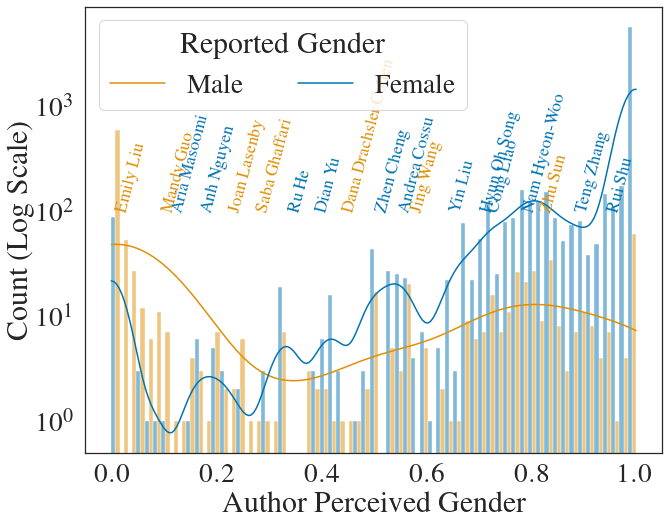

In [855]:
plt_dat  = author_gender[~author_gender.perceived_gender.isna()]
plt_dat = plt_dat[plt_dat.reported_gender.isin(['Male','Female'])]
plt_dat = plt_dat.rename({'reported_gender':'Reported Gender'},axis=1)
ax = sns.histplot(data=plt_dat,
                  x='perceived_gender',
             log_scale=(False,True),
             kde=True,
                  hue='Reported Gender',
                multiple='dodge',
            )

ax.set(xlabel=r'Author Perceived Gender', 
       ylabel=r'Count (Log Scale)')

ax.legend(['Male','Female'],title='Reported Gender', ncol=2)
for i in range(19):
    row = (plt_dat
           .query(f"(perceived_gender > {i*0.05}) & (perceived_gender<= {(i+1)*0.05})")
          ).sample(1).iloc[0]
    ax.text(row.perceived_gender, 100,  
            row['name'],
            rotation=75,
     size='xx-small', 
     color='C0' if row['Reported Gender']=='Male' else 'C1',
     weight='light',
     fontstretch='semi-condensed',
    )
    

plt.tight_layout()
plt.savefig('./figs/hist_author_gender.png',bbox_inches='tight')
plt.savefig('./figs/hist_author_gender.pdf',bbox_inches='tight')



<ipython-input-856-c5b6297e0862>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_dat['reported_gender'] =\
<ipython-input-856-c5b6297e0862>:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "axis" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figs/box_author_gender.png',axis=1)
<ipython-input-856-c5b6297e0862>:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "axis" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figs/box_author_gender.pdf',axis=1)


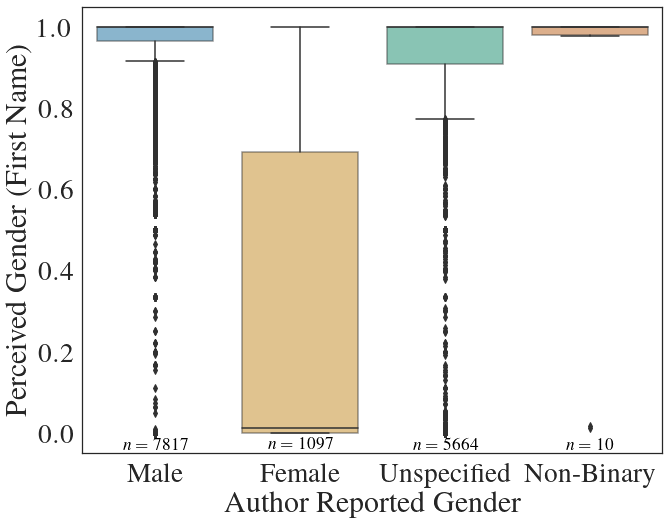

In [856]:
plt_cats = ['Male','Female', 'Unspecified','Non-Binary']
plt_dat = author_gender[~author_gender.isna().any(axis=1)]
plt_dat['reported_gender'] =\
    pd.Categorical(plt_dat['reported_gender'], plt_cats)

ax=sns.boxplot(data=plt_dat,
             x='reported_gender',
             y='perceived_gender',
               boxprops=dict(alpha=.5)
)

ax.set(xlabel=r'Author Reported Gender', 
       ylabel=r'Perceived Gender (First Name)')

for i, cat in enumerate(plt_cats):
    vals = plt_dat.query(f"reported_gender=='{cat}'").perceived_gender.values
    ax.text(i, -0.04,
            rf"$n={vals.shape[0]}$",
            rotation=0,
     size='xx-small', 
     color='black',
         weight='bold',
    horizontalalignment='center', 
     fontstretch='semi-condensed',
    )
    
    
plt.tight_layout()
plt.savefig('./figs/box_author_gender.png',axis=1)
plt.savefig('./figs/box_author_gender.pdf',axis=1)

In [ ]:
decisions=decisions.replace({'decision': {
    'Accept (Poster)':'Accept',
    'Accept (Spotlight)':'Accept',
    'Accept (Oral)':'Accept',
    'Accept (Talk)':'Accept',
    'Invite to Workshop Track':'Reject',}
                   
    })

In [1577]:
sub_gender = (author_sub
 .merge(author_gender,on='author_id')
 .merge(decisions[['forum','decision']].rename(
    {'forum':'submission_id'},axis=1),
        on='submission_id'
    )
)


In [1579]:
sub_gender_nona = sub_gender[~sub_gender.reported_gender.isna()]

In [1581]:
sub_gender_nona['has_female']=(sub_gender_nona
 .groupby(['submission_id'])
 .perceived_gender
 .transform(lambda grp:  (grp=='Female').any())
)

In [1586]:
plt_dat=sub_gender_nona[[
    'submission_id','decision','has_female'
    ]].drop_duplicates('submission_id')

## Teaser

In [61]:
import wordcloud

In [74]:
keyword_freq = (sub_keyword
 .groupby('keyword').count().reset_index().set_index('keyword')
 .rename({'submission_id':'count'},axis=1)
 .sort_values('count', ascending=False)
).to_dict()['count']

In [94]:
wc = wordcloud.WordCloud(background_color='white',
                        width=1600, height=500,
                          relative_scaling = 0.5,
                        ).fit_words(keyword_freq)

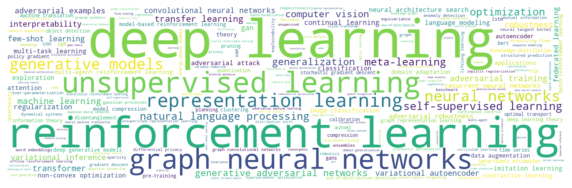

In [95]:
plt.imshow(wc, interpolation='bilinear')

plt.axis("off")
plt.savefig("./figs/word_cloud_all.png", bbox_inches='tight')

### arxiv

In [12]:
vec_embds = pd.read_csv(DATA_PATH/"submission_specter_embedding.csv")
utils.lit_eval_df(vec_embds, ['encoded_vec'])

In [13]:
vec_embds['vec'] = vec_embds.encoded_vec.apply(
    lambda x : np.array(x)/np.linalg.norm(x))

vec_embds= vec_embds.rename({'id':'submission_id'},axis=1)

In [14]:
vec_embds=vec_embds.merge(matched_sub[['submission_id',
        'primary_category', 'published_time']],
        on='submission_id',
       how='left'
)
vec_embds_arx=vec_embds[~vec_embds.primary_category.isna()].reset_index(
drop=True)

In [16]:
import sklearn
import sklearn.cluster
import sklearn.manifold
Xvec = np.vstack(vec_embds['vec'].values)
Xcls = sklearn.cluster.SpectralClustering(n_clusters=20,
    assign_labels='discretize',).fit(Xvec)
Yvec = Xcls.labels_
vec_embds['cluster'] = Yvec

In [18]:
Xvec_arxiv = np.vstack(vec_embds_arx['vec'].values)

X_tsne = sklearn.manifold.TSNE(n_components=2,
 init='random').fit_transform(Xvec_arxiv.astype(float))
vec_embds_arx['x0']=X_tsne[:,0]
vec_embds_arx['x1']=X_tsne[:,1]

In [21]:
sub_kwd = dataloader('submission_main_keyword')

In [22]:
vec_embds_arx=(vec_embds_arx
 .merge(sub_kwd,how='left')              
)

In [23]:
vec_embds_arx['category'] =\
 vec_embds_arx.primary_category.apply(
    lambda s : s.split('.')[0]
)

In [24]:
plt_cats=sorted(['cs.CL','cs.CV','stat.ML','cs.AI'])

In [27]:
plt_arx_dat = (vec_embds_arx[vec_embds_arx
        .primary_category.isin(plt_cats)]
        .sort_values('primary_category')
          ).merge(
    submissions[['submission_id','title']]
)

In [48]:
matplotlib.rc('text', usetex=True)
import textwrap
sns.set(font_scale=2,)

sns.set_style("white")
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette("colorblind")


In [139]:
sample_df = []
ddt = plt_arx_dat[~plt_arx_dat.primary_keyword.isna()]
ddt = ddt[(ddt.x0<=-20) & (ddt.x0<35)]
for n_smp in range(30):

    if len(sample_df) != 0:
        ddt = ddt[ddt.apply(lambda s : 
        (abs(s.x0-sample_df[-1].iloc[0].x0) > 1) and \
                  (abs(s.x1-sample_df[-1].iloc[0].x1)>=5)
        ,axis=1)]
    if(len(ddt)==0):
        print(f"drawn {n_smp+1} samples")
        break
    sample_df.append(ddt.sample(1))


drawn 8 samples


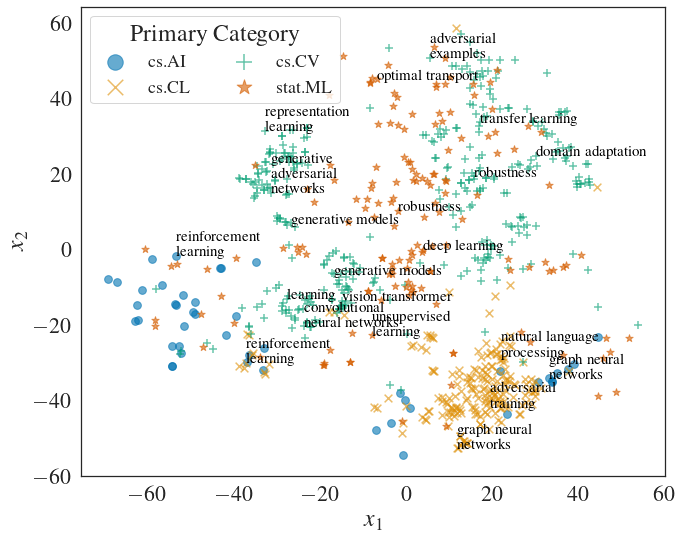

In [140]:
ax = plt.gca()

for cidx, cat in enumerate(plt_cats):

    dt = plt_arx_dat.query(f"primary_category=='{cat}'")
    ax.scatter(dt['x0'],dt['x1'],c=f"C{cidx}",marker=['o','x','+','*'][cidx],
              s=60,alpha=.6,label=cat)
    
ax.legend(title='Primary Category', 
           loc=2, ncol=2,fontsize=18, markerscale=2
          )
for rid, row in pd.concat(sample_df).iterrows():
    
    ax.text(row.x0+0.01, row.x1,  
            textwrap.fill(
                row.primary_keyword,
                18),
    horizontalalignment='left', 
            fontsize=15, fontfamily='sans-serif',
            color='black', weight='light',
            fontstretch='condensed',
           )


ax.set(xlabel=r'$x_1$', 
       ylabel=r'$x_2$')

plt.tight_layout()
plt.savefig('./figs/tsne_specter_arxiv.png',bbox_inches='tight')
plt.savefig('./figs/tsne_specter_arxiv.pdf',bbox_inches='tight')

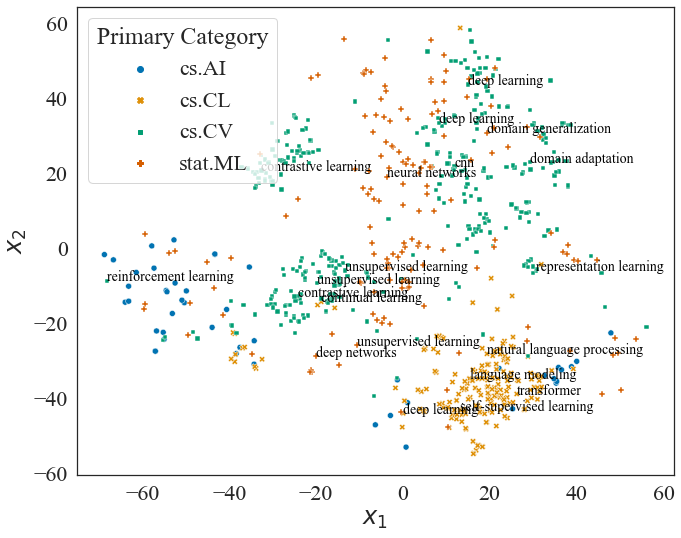

In [971]:


ax=sns.scatterplot(data=plt_dat,
                x="x0", y="x1", 
#                 hue="primary_keyword"
                hue="primary_category",
                style="primary_category",
#                    sizes=(20, 200)
               )


ax.set(xlabel=r'$x_1$', 
       ylabel=r'$x_2$')

for rid, row in (plt_dat[~plt_dat.primary_keyword.isna()]
                 .sample(20).iterrows()):

    ax.text(row.x0+0.01, row.x1,  
            row.primary_keyword,#+','+row.secondary_keyword,
    horizontalalignment='left', 
     size='xx-small', color='black', weight='light',
            fontstretch='semi-condensed',
           )



plt.legend(title='Primary Category', 
           loc=2, 
          )
plt.tight_layout()
plt.savefig('./figs/tsne_specter_arxiv.png')